In [20]:
import json
import time
import datetime
import random
import bz2

In [105]:
# unique_chains variable name is legacy
def gen_unique_chains(tree, unique_chains):
    user = tree['source_user_id']
    
    if user not in unique_chains.keys():
        unique_chains[user] = {
            'unique_chains': 0,
            'root_comments': 0,
            'total_comments': 0,
        }
    
    # add-on analyses
    if int(tree['depth']) == 0:
        unique_chains[user]['root_comments'] += 1
    unique_chains[user]['total_comments'] += 1
    
    # base case
    if len(tree['children']) == 0:
        unique_chains[user]['unique_chains'] += 1
        return set(user)
    
    # recursive case
    seen_users = set()
    for child in tree['children']:
        # assume pass by reference for unique_chains dict
        # set to set addition: https://www.techiedelight.com/add-values-to-set-python/
        seen_users = seen_users | gen_unique_chains(child, unique_chains)
    
    # combine
    if user not in seen_users:
        seen_users.add(user)
        unique_chains[user]['unique_chains'] += 1

    return seen_users

In [108]:
def write_unique_chains(tree, visit_file):
    unique_chains = dict()
    gen_unique_chains(tree, unique_chains)
    unique_chains.pop('placeholder')
        
    for user in unique_chains.keys():
        count_unique_chains = unique_chains[user]['unique_chains']
        root_comments = unique_chains[user]['root_comments']
        total_comments = unique_chains[user]['total_comments']

        visit_file.write('{0},{1},{2},{3},{4}\n'.format(tree['video_id'], 
                                               user, 
                                               count_unique_chains, 
                                               root_comments, 
                                               total_comments)
                        )
    
    return unique_chains

In [110]:
try:
    i = 0
    vid_count = 0
    
    current_vid = '-1'
    video_comments = []
    
    print('time start: {0}'.format(datetime.datetime.now()))
    with bz2.BZ2File('../convo_trees.bz2') as in_file:
        with open('./visit.csv', 'at') as visit_file:
            visit_file.write('{0},{1},{2},{3},{4}\n'.format('video_id', 
                                       'user_id', 
                                       'unique_chains', 
                                       'root_comments', 
                                       'total_comments')
                            )
        
            for line in in_file:
                line = line.decode('utf-8')
                line = line.rstrip()
                
                tree = json.loads(line)
                
                video_comments.append(tree)
                
                if tree['video_id'] != current_vid:
                    video_tree = {'source_user_id': 'placeholder', 
                                  'video_id': current_vid, 
                                  'children': video_comments,
                                  'depth': -1
                                 } 
                    
                    unique_chains = write_unique_chains(video_tree, visit_file)
                    
                    #print(video_tree)
                    #print(unique_chains)


                    current_vid = tree['video_id']
                    video_comments = []
                    
                    if vid_count % 1000 == 0:
                        print('checkin: video #{0}'.format(vid_count))
                    vid_count += 1
                    #if vid_count == 10:
                        #break
                
                
                #if i == 1000:
                    #break
                if i % 1000000 == 0:
                    print('checkin: tree #{0}'.format(i))
                
                i += 1

except:
    print('tree: {0}'.format(video_tree))
    raise
finally:
    print('iterations: {0}'.format(i))
    print('time end: {0}'.format(datetime.datetime.now()))

time start: 2022-07-20 01:03:03.073408
checkin: video #0
checkin: tree #0
checkin: video #1000
checkin: video #2000
checkin: video #3000
checkin: tree #1000000
checkin: video #4000
checkin: video #5000
checkin: tree #2000000
checkin: video #6000
checkin: video #7000
checkin: video #8000
checkin: video #9000
checkin: tree #3000000
checkin: video #10000
checkin: video #11000
checkin: video #12000
checkin: tree #4000000
checkin: video #13000
checkin: video #14000
checkin: video #15000
checkin: tree #5000000
checkin: video #16000
checkin: video #17000
checkin: video #18000
checkin: tree #6000000
checkin: video #19000
checkin: video #20000
checkin: video #21000
checkin: video #22000
checkin: tree #7000000
checkin: video #23000
checkin: video #24000
checkin: video #25000
checkin: tree #8000000
checkin: video #26000
checkin: video #27000
checkin: video #28000
checkin: tree #9000000
checkin: video #29000
checkin: video #30000
checkin: video #31000
checkin: tree #10000000
checkin: video #32000


In [41]:
import pandas as pd

In [42]:
# few minutes
df = pd.read_csv('./visit.csv')

In [43]:
df.shape

(83965424, 5)

In [44]:
df.columns

Index(['video_id', 'user_id', 'unique_chains', 'root_comments',
       'total_comments'],
      dtype='object')

In [45]:
def get_user_leanings_dict():
    user_leanings_dict = {}

    with open('../user_leanings.csv') as file:
        for line in file:
            vals = line.rstrip().split(",")
            user_leanings_dict[vals[0]] = vals[1]

    return user_leanings_dict

In [46]:
# few seconds
#user_leanings_dict = get_user_leanings_dict()

In [47]:
def get_videos_leanings_dict():
    vid_leanings_dict = {}

    with bz2.BZ2File('../video_leanings.json.bz2') as file:
        i = 0
        for line in file:
            # TODO: Is json loads super slow?
            vals = json.loads(line.rstrip())
            vid = vals['vid']
            leaning = vals['media_ideology']
            vid_leanings_dict[vid] = leaning

            #if i == 100:
                #break

            if i % 1000000 == 0:
                print('checkin: iteration #{0}'.format(i))
            i += 1

    return vid_leanings_dict

In [48]:
# 23 minutes (!!!)
#video_leanings_dict = get_videos_leanings_dict()

In [49]:
# few seconds
df['unique_chain_ratio'] = df['unique_chains'] * 1.0 / df['total_comments']


In [50]:
# few seconds
df['root_ratio'] = df['root_comments'] * 1.0 / df['total_comments']

In [51]:
# consider making a join?
# 12 minutes
df['leaning'] = df.apply(
    lambda row: user_leanings_dict[row['user_id']] if row['user_id'] in user_leanings_dict else '-1',
    axis=1
)

In [52]:
# 15 minutes
df['video_leaning'] = df.apply(
    lambda row: video_leanings_dict[row['video_id']] if row['video_id'] in video_leanings_dict else '-1',
    axis=1
)

In [53]:
# ~20 seconds
df = df[
    ~
    (
    (df['video_leaning']=='-1') |
    (df['leaning']=='-1')
    )
]

In [54]:
# a few seconds

# For each leaning, plot the unique chain ratio vs. the number of total comments
by_total_comments = df.groupby(['video_leaning', 'leaning','total_comments'])['unique_chain_ratio'].agg('mean')


In [69]:
by_total_comments.head(20)

video_leaning  leaning  total_comments
L              L        1                 1.000000
                        2                 0.963205
                        3                 0.917717
                        4                 0.887876
                        5                 0.867943
                        6                 0.857269
                        7                 0.850459
                        8                 0.845146
                        9                 0.841256
                        10                0.839648
                        11                0.836523
                        12                0.835956
                        13                0.834174
                        14                0.832997
                        15                0.832069
                        16                0.834082
                        17                0.828770
                        18                0.834660
                        19                0

video_leaning  leaning
L              L          AxesSubplot(0.125,0.125;0.775x0.755)
               R          AxesSubplot(0.125,0.125;0.775x0.755)
R              L          AxesSubplot(0.125,0.125;0.775x0.755)
               R          AxesSubplot(0.125,0.125;0.775x0.755)
Name: unique_chain_ratio, dtype: object

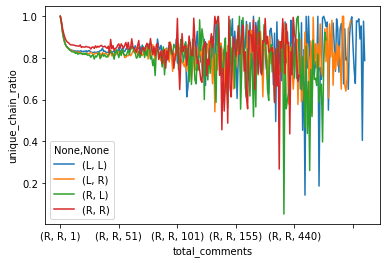

In [55]:

by_total_comments.groupby(['video_leaning', 'leaning']).plot(xlabel='total_comments', ylabel='unique_chain_ratio', legend=True)



In [76]:
df.groupby(['video_leaning', 'leaning'])['unique_chain_ratio'].agg(['count', 'mean'])


count      mean
video_leaning leaning                    
L             L        26723982  0.985043
              R        11240999  0.982097
R             L         4559803  0.982707
              R        23913699  0.990811

In [70]:
df.groupby(['video_leaning', 'leaning']).agg('count')

video_id   user_id  unique_chains  root_comments  \
video_leaning leaning                                                     
L             L        26723982  26723982       26723982       26723982   
              R        11240999  11240999       11240999       11240999   
R             L         4559803   4559803        4559803        4559803   
              R        23913699  23913699       23913699       23913699   

                       total_comments  unique_chain_ratio  root_ratio  
video_leaning leaning                                                  
L             L              26723982            26723982    26723982  
              R              11240999            11240999    11240999  
R             L               4559803             4559803     4559803  
              R              23913699            23913699    23913699

video_leaning  leaning
L              L          AxesSubplot(0.125,0.125;0.775x0.755)
               R          AxesSubplot(0.125,0.125;0.775x0.755)
R              L          AxesSubplot(0.125,0.125;0.775x0.755)
               R          AxesSubplot(0.125,0.125;0.775x0.755)
Name: unique_chain_ratio, dtype: object

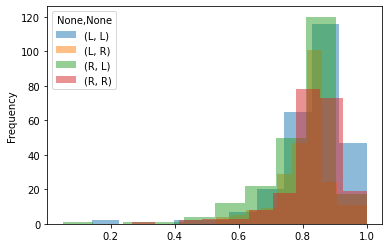

In [58]:

by_total_comments.groupby(['video_leaning', 'leaning']).plot(kind='hist', xlabel='unique_chain_ratio', ylabel='count', legend=True, alpha=.5)



In [59]:
# answering siqi's question
# for each leaning, find the average visit's percentage of comments that are root
df.groupby(['video_leaning', 'leaning'])['root_ratio'].agg('mean')


video_leaning  leaning
L              L          0.710828
               R          0.719561
R              L          0.712958
               R          0.792573
Name: root_ratio, dtype: float64

In [73]:
# ~20 seconds
df_try = df[
    ~(df['total_comments']==1)
]

In [75]:
df_try.groupby(['video_leaning', 'leaning'])['unique_chain_ratio'].agg(['count', 'mean'])


count      mean
video_leaning leaning                   
L             L        5705154  0.929937
              R        2711997  0.925794
R             L        1074450  0.926609
              R        4489534  0.951056

In [77]:
# ~20 seconds
df_try = df[
    ~(df['total_comments']<50)
]

In [78]:
df_try.groupby(['video_leaning', 'leaning'])['unique_chain_ratio'].agg(['count', 'mean'])


count      mean
video_leaning leaning                 
L             L         5307  0.837876
              R         4372  0.819159
R             L         2493  0.817195
              R         2001  0.847451